In [1]:
from typing import Dict, List, Optional, Tuple, Union

import torch
import torch.nn as nn


class BaseConceptualModel(nn.Module):
    """Abstract base model class, don't use this class for model training!

    The purpose is to have some common operations that all conceptual models will need.
    """

    def __init__(
        self,
    ):
        super(BaseConceptualModel, self).__init__()

    def forward(self, x_conceptual: torch.Tensor, lstm_out: torch.Tensor
    ) -> Dict[str, Union[torch.Tensor, Dict[str, torch.Tensor]]]:
        raise NotImplementedError

    def map_parameters(self, lstm_out: torch.Tensor, warmup_period: int
    ) -> Tuple[Dict[str, torch.Tensor], Dict[str, torch.Tensor]]:
        """Map output of data-driven part to predefined ranges of the conceptual model parameters.

        The result are two dictionaries, one contains the parameters for the warmup period of the conceptual model and
        the other contains the parameters for the simulation period. Moreover, the parameterization can be static or
        dynamic. In the static parameterization the last value is repeated over the whole timeseries, while in the
        dynamic parameterization we have one parameter set for each time step.

        Note:
            The dynamic parameterization only occurs in the simulation phase, not the warmup! The warmup always uses
            static parameterization. Therefore, in case we specified dynamic parameterization, for the warmup period,
            we take the last value of this period and repeat it throughout the warmup phase.

        Parameters
        ----------
        lstm_out : torch.Tensor
            Tensor of size [batch_size, time_steps, n_param] that will be mapped to the predefined ranges of the
            conceptual model parameters to act as the dynamic parameterization.
        warmup_period : int
            Number of timesteps (e.g. days) to warmup the internal states of the conceptual model

        Returns
        -------
        Tuple[Dict[str, torch.Tensor], Dict[str, torch.Tensor]]
            - parameters_warmup : Dict[str, torch.Tensor]
                Parameters for the warmup period (always static!)
            - parameters_simulation : Dict[str, torch.Tensor]
                Parameterization of the conceptual model in the training/testing period. Can be static or dynamic
        """
        # Reshape tensor to consider multiple conceptual models running in parallel.
        lstm_out = lstm_out.view(lstm_out.shape[0], lstm_out.shape[1], -1, self.n_conceptual_models)

        parameters_warmup = {}
        parameters_simulation = {}
        for index, (parameter_name, parameter_range) in enumerate(self.parameter_ranges.items()):
            range_t = torch.tensor(parameter_range, dtype=torch.float32, device=lstm_out.device)
            range_t = range_t.unsqueeze(dim=1).unsqueeze(dim=2)

            if self.parameter_type[parameter_name] == "static":
                # If parameter is static, take the last value predicted by the lstm and copy it for all the timesteps.
                warmup_lstm_out = lstm_out[:, -1:, index, :].expand(-1, warmup_period, -1)
                simulation_lstm_out = lstm_out[:, -1:, index, :].expand(-1, lstm_out.shape[1] - warmup_period, -1)
            elif self.parameter_type[parameter_name] == "dynamic":
                warmup_lstm_out = lstm_out[:, warmup_period - 1 : warmup_period, index, :].expand(-1, warmup_period, -1)
                simulation_lstm_out = lstm_out[:, warmup_period:, index, :]
            else:
                raise ValueError(f"Unsupported parameter type {self.parameter_type[parameter_name]}")

            parameters_warmup[parameter_name] = range_t[:1, :, :] + torch.sigmoid(warmup_lstm_out) * (
                range_t[1:, :, :] - range_t[:1, :, :]
            )
            parameters_simulation[parameter_name] = range_t[:1, :, :] + torch.sigmoid(simulation_lstm_out) * (
                range_t[1:, :, :] - range_t[:1, :, :]
            )

        return parameters_warmup, parameters_simulation

    def _map_parameter_type(self, parameter_type: List[str] = None)-> Dict[str, str]:
        """Define parameter type, static or dynamic.

        The model parameters can be static or dynamic. This function creates a dictionary that associate the parameter
        name with a type specified by the user. In case the user did not specify a type, the parameter_type is
        automatically specified as static.

        Parameters
        ----------
        parameter_type : List[str]
            List to specify which parameters of the conceptual model will be dynamic.

        Returns
        -------
        map_parameter_type: Dict[str, str]
            Dictionary
        """
        map_parameter_type = {}
        for key, _ in self.parameter_ranges.items():
            if parameter_type is not None and key in parameter_type:  # if user specified the type
                map_parameter_type[key] = "dynamic"
            else:  # default initialization
                map_parameter_type[key] = "static"

        return map_parameter_type

    def _initialize_information(self, conceptual_inputs: torch.Tensor) -> Tuple[Dict[str, torch.Tensor], torch.Tensor]:
        """Initialize structures to store the time evolution of the internal states and the outflow

        Parameters
        ----------
        conceptual_inputs: torch.Tensor
            Inputs of the conceptual model

        Returns
        -------
        Tuple[Dict[str, torch.Tensor], torch.Tensor]
            - states: Dict[str, torch.Tensor]
                Dictionary to store the time evolution of the internal states (buckets) of the conceptual model
            - q_out: torch.Tensor
                Tensor to store the outputs of the conceptual model
        """
        states = {}
        # initialize dictionary to store the evolution of the states
        for name, _ in self._initial_states.items():
            states[name] = torch.zeros(
                (conceptual_inputs.shape[0], conceptual_inputs.shape[1], self.n_conceptual_models),
                dtype=torch.float32,
                device=conceptual_inputs.device,
            )

        # initialize vectors to store the evolution of the outputs
        out = torch.zeros(
            (conceptual_inputs.shape[0], conceptual_inputs.shape[1], self.output_size),
            dtype=torch.float32,
            device=conceptual_inputs.device,
        )

        return states, out

    def _get_final_states(self, states: Dict[str, torch.Tensor]) -> Dict[str, torch.Tensor]:
        """Recovers final states of the conceptual model.

        Parameters
        ----------
        states : Dict[str, torch.Tensor]
            Dictionary with the time evolution of the internal states (buckets) of the conceptual model

        Returns
        -------
        Dict[str, torch.Tensor]
            Dictionary with the internal states (buckets) of the conceptual model, on the last timestep
        """
        return {name: state[:, -1, :] for name, state in states.items()}

    @property
    def _initial_states(self) -> Dict[str, float]:
        raise NotImplementedError

    @property
    def parameter_ranges(self) -> Dict[str, List[float]]:
        raise NotImplementedError

class HBV(BaseConceptualModel):
    """HBV model.

    Implementation based on Feng et al. [1]_ and Seibert [2]_. The code creates a modified version of the HBV model that
    can be used as a differentiable entity to create hybrid models. One can run multiple entities of the model at the
    same time.

    Parameters
    ----------
    n_models : int
        Number of model entities that will be run at the same time
    parameter_type : List[str]
        List to specify which parameters of the conceptual model will be dynamic.

    References
    ----------
    .. [1] Feng, D., Liu, J., Lawson, K., & Shen, C. (2022). Differentiable, learnable, regionalized process-based
        models with multiphysical outputs can approach state-of-the-art hydrologic prediction accuracy. Water Resources
        Research, 58, e2022WR032404. https://doi.org/10.1029/2022WR032404
    .. [2] Seibert, J. (2005) HBV Light Version 2. User’s Manual. Department of Physical Geography and Quaternary
        Geology, Stockholm University, Stockholm
    """

    def __init__(self, n_models: int = 1, parameter_type: List[str] = None):
        super(HBV, self).__init__()
        self.n_conceptual_models = n_models
        self.parameter_type = self._map_parameter_type(parameter_type=parameter_type)
        self.output_size = 1

    def forward(self, x_conceptual: torch.Tensor, parameters: Dict[str, torch.Tensor],
                initial_states: Optional[Dict[str, torch.Tensor]] = None,
    ) -> Dict[str, Union[torch.Tensor, Dict[str, torch.Tensor]]]:
        """Forward pass on the HBV model.

        Parameters
        ----------
        x_conceptual: torch.Tensor
            Tensor of size [batch_size, time_steps, n_inputs]. The batch_size is associated with a certain basin and a
            certain prediction period. The time_steps refer to the number of time steps (e.g. days) that our conceptual
            model is going to be run for. The n_inputs refer to the dynamic forcings used to run the conceptual model
            (e.g. Precipitation, Temperature...)
        parameter_type : List[str]
            List to specify which parameters of the conceptual model will be dynamic.
        initial_states: Optional[Dict[str, torch.Tensor]]
            Optional parameter! In case one wants to specify the initial state of the internal states of the conceptual
            model.

        Returns
        -------
        Dict[str, Union[torch.Tensor, Dict[str, torch.Tensor]]
            - y_hat: torch.Tensor
                Simulated outflow
            - parameters: Dict[str, torch.Tensor]
                Dynamic parameterization of the conceptual model
            - internal_states: Dict[str, torch.Tensor]
                Time-evolution of the internal states of the conceptual model
            - last_states: Dict[str, torch.Tensor]
                Internal states of the conceptual model in the last timestep
        """
        # initialize structures to store the information
        states, out = self._initialize_information(conceptual_inputs=x_conceptual)

        # initialize constants
        zero = torch.tensor(0.0, dtype=torch.float32, device=x_conceptual.device)

        # Broadcast tensor to consider multiple conceptual models running in parallel
        precipitation = torch.tile(x_conceptual[:, :, 0].unsqueeze(2), (1, 1, self.n_conceptual_models))
        et = torch.tile(x_conceptual[:, :, 1].unsqueeze(2), (1, 1, self.n_conceptual_models))
        if x_conceptual.shape[2] == 4:  # the user specified tmax and tmin
            temperature = (x_conceptual[:, :, 2] + x_conceptual[:, :, 3]) / 2
        else:
            temperature = x_conceptual[:, :, 2]
        temperature = torch.tile(temperature.unsqueeze(2), (1, 1, self.n_conceptual_models))

        # Division between solid and liquid precipitation can be done outside of the loop
        temp_mask = temperature < parameters["TT"]
        liquid_p = precipitation.clone()
        liquid_p[temp_mask] = zero
        snow = precipitation.clone()
        snow[~temp_mask] = zero

        if initial_states is None:  # if we did not specify initial states it takes the default values
            SNOWPACK = torch.full(
                (x_conceptual.shape[0], self.n_conceptual_models),
                self._initial_states["SNOWPACK"],
                dtype=torch.float32,
                device=x_conceptual.device,
            )
            MELTWATER = torch.full(
                (x_conceptual.shape[0], self.n_conceptual_models),
                self._initial_states["MELTWATER"],
                dtype=torch.float32,
                device=x_conceptual.device,
            )
            SM = torch.full(
                (x_conceptual.shape[0], self.n_conceptual_models),
                self._initial_states["SM"],
                dtype=torch.float32,
                device=x_conceptual.device,
            )
            SUZ = torch.full(
                (x_conceptual.shape[0], self.n_conceptual_models),
                self._initial_states["SUZ"],
                dtype=torch.float32,
                device=x_conceptual.device,
            )
            SLZ = torch.full(
                (x_conceptual.shape[0], self.n_conceptual_models),
                self._initial_states["SLZ"],
                dtype=torch.float32,
                device=x_conceptual.device,
            )
        else:  # we specify the initial states
            SNOWPACK = initial_states["SNOWPACK"]
            MELTWATER = initial_states["MELTWATER"]
            SM = initial_states["SM"]
            SUZ = initial_states["SUZ"]
            SLZ = initial_states["SLZ"]

        # run hydrological model for each time step
        for j in range(x_conceptual.shape[1]):
            # Snow module -----------------------------------------------------------------------------------------
            SNOWPACK = SNOWPACK + snow[:, j, :]
            melt = parameters["CFMAX"][:, j, :] * (temperature[:, j, :] - parameters["TT"][:, j, :])
            melt = torch.clamp(melt, min=0.0)
            melt = torch.min(melt, SNOWPACK)
            MELTWATER = MELTWATER + melt
            SNOWPACK = SNOWPACK - melt
            refreezing = (
                parameters["CFR"][:, j, :]
                * parameters["CFMAX"][:, j, :]
                * (parameters["TT"][:, j, :] - temperature[:, j, :])
            )
            refreezing = torch.clamp(refreezing, min=0.0)
            refreezing = torch.min(refreezing, MELTWATER)
            SNOWPACK = SNOWPACK + refreezing
            MELTWATER = MELTWATER - refreezing
            tosoil = MELTWATER - (parameters["CWH"][:, j, :] * SNOWPACK)
            tosoil = torch.clamp(tosoil, min=0.0)
            MELTWATER = MELTWATER - tosoil

            # Soil and evaporation ---------------------------------------------------------------------------------
            soil_wetness = (SM / parameters["FC"][:, j, :]) ** parameters["BETA"][:, j, :]
            soil_wetness = torch.clamp(soil_wetness, min=0.0, max=1.0)
            recharge = (liquid_p[:, j, :] + tosoil) * soil_wetness

            SM = SM + liquid_p[:, j, :] + tosoil - recharge
            excess = SM - parameters["FC"][:, j, :]
            excess = torch.clamp(excess, min=0.0)
            SM = SM - excess
            if "BETAET" in parameters:
                evapfactor = (SM / (parameters["LP"][:, j, :] * parameters["FC"][:, j, :])) ** parameters["BETAET"][
                    :, j, :
                ]
            else:
                evapfactor = SM / (parameters["LP"][:, j, :] * parameters["FC"][:, j, :])
            evapfactor = torch.clamp(evapfactor, min=0.0, max=1.0)
            ETact = et[:, j, :] * evapfactor
            ETact = torch.min(SM, ETact)
            SM = torch.clamp(SM - ETact, min=1e-5)  # SM can not be zero for gradient tracking

            # Groundwater boxes -------------------------------------------------------------------------------------
            SUZ = SUZ + recharge + excess
            PERC = torch.min(SUZ, parameters["PERC"][:, j, :])
            SUZ = SUZ - PERC
            Q0 = parameters["K0"][:, j, :] * torch.clamp(SUZ - parameters["UZL"][:, j, :], min=0.0)
            SUZ = SUZ - Q0
            Q1 = parameters["K1"][:, j, :] * SUZ
            SUZ = SUZ - Q1
            SLZ = SLZ + PERC
            Q2 = parameters["K2"][:, j, :] * SLZ
            SLZ = SLZ - Q2

            # Store time evolution of the internal states
            states["SNOWPACK"][:, j, :] = SNOWPACK
            states["MELTWATER"][:, j, :] = MELTWATER
            states["SM"][:, j, :] = SM
            states["SUZ"][:, j, :] = SUZ
            states["SLZ"][:, j, :] = SLZ

            # total outflow
            out[:, j, 0] = torch.mean(Q0 + Q1 + Q2, dim=1)  # [mm]

        # last states
        final_states = self._get_final_states(states=states)

        return {"y_hat": out, "parameters": parameters, "internal_states": states, "final_states": final_states}

    @property
    def _initial_states(self) -> Dict[str, float]:
        return {"SNOWPACK": 0.001, "MELTWATER": 0.001, "SM": 0.001, "SUZ": 0.001, "SLZ": 0.001}

    @property
    def parameter_ranges(self) -> Dict[str, Tuple[float, float]]:
        return {
            "BETA": (1.0, 6.0),
            "FC": (50.0, 1000.0),
            "K0": (0.05, 0.9),
            "K1": (0.01, 0.5),
            "K2": (0.001, 0.2),
            "LP": (0.2, 1.0),
            "PERC": (0.0, 10.0),
            "UZL": (0.0, 100.0),
            "TT": (-2.5, 2.5),
            "CFMAX": (0.5, 10.0),
            "CFR": (0.0, 0.1),
            "CWH": (0.0, 0.2),
            "BETAET": (0.3, 5.0),
        }


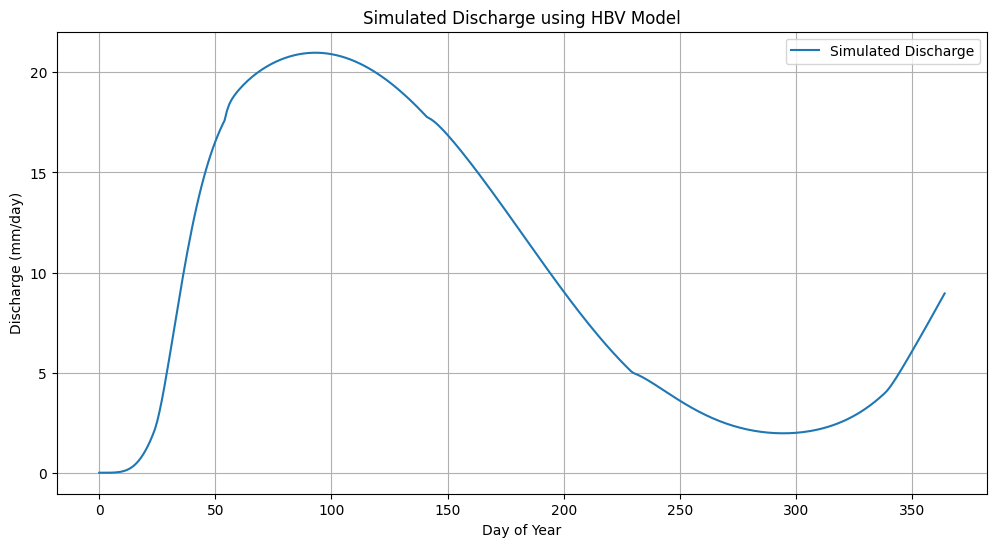

In [2]:
import torch
import matplotlib.pyplot as plt
from hbv import HBV

# Step 1: Create an instance of the HBV model
hbv_model = HBV(n_models=1)

# Step 2: Prepare synthetic input data
time_steps = 365
batch_size = 1

days = torch.arange(0, time_steps)
precipitation = 10 * torch.sin(2 * torch.pi * days / 365) + 15
precipitation = precipitation.unsqueeze(0).unsqueeze(2)

et = 4 * torch.ones((batch_size, time_steps, 1))

temperature = 10 * torch.sin(2 * torch.pi * days / 365) + 10
temperature = temperature.unsqueeze(0).unsqueeze(2)

x_conceptual = torch.cat([precipitation, et, temperature], dim=2)

# Step 3: Prepare model parameters
parameter_ranges = hbv_model.parameter_ranges

parameters = {}
for param_name, (min_val, max_val) in parameter_ranges.items():
    mid_val = (min_val + max_val) / 2
    parameters[param_name] = torch.full(
        (batch_size, time_steps, hbv_model.n_conceptual_models),
        mid_val,
        dtype=torch.float32
    )

parameters['FC'] = torch.full(
    (batch_size, time_steps, hbv_model.n_conceptual_models),
    500.0,
    dtype=torch.float32
)

# Step 4: Run the HBV model
outputs = hbv_model.forward(x_conceptual, parameters)
simulated_discharge = outputs['y_hat'].detach().numpy().squeeze()

# Step 5: Visualize the results
plt.figure(figsize=(12, 6))
plt.plot(days, simulated_discharge, label='Simulated Discharge')
plt.xlabel('Day of Year')
plt.ylabel('Discharge (mm/day)')
plt.title('Simulated Discharge using HBV Model')
plt.legend()
plt.grid()
plt.show()
